# Neural style transfer

In [1]:
# Defining initial variables
from keras.preprocessing.image import load_img, img_to_array

target_image_path = 'target.jpg'
style_reference_image_path = 'reference.jpg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [2]:
# Auxiliary functions
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
# Loading the pretrained VGG19 network and applying it to the three images
from keras import backend as K
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model loaded.


In [4]:
# Content loss
def content_loss(base, combination):
    return K.sum(K.square(combination-base))

In [5]:
# Style loss
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [6]:
# Total variation loss (to avoid overly pixelated results)
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height-1, :img_width-1, :] - 
        x[:, 1:, :img_width-1, :])
    b = K.square(
        x[:, :img_height-1, :img_width-1, :] - 
        x[:, :img_height-1, 1:, :])
    return K.sum(K.pow(a+b, 1.25))

In [7]:
# Defining the final loss that you'll minimize
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
# A hight content_weight means the target content will be more recognizable
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl

loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [8]:
# Setting up the gradient-descent process
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grads_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grads_values = grads_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_values)
        self.loss_value = None
        self.grads_values = None
        return grads_values

evaluator = Evaluator()

In [9]:
# Style-transfer loop
from scipy.optimize import fmin_l_bfgs_b
from imageio import imwrite
import time

result_prefix = 'my_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imwrite(fname, img)
    print('Image saved as', fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time-start_time))

Start of iteration 0
Current loss value: 8561329700.0
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 15s
Start of iteration 1
Current loss value: 4583138300.0
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 10s
Start of iteration 2
Current loss value: 3160839700.0
Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 10s
Start of iteration 3
Current loss value: 2552422700.0
Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 9s
Start of iteration 4
Current loss value: 2182432800.0
Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 9s
Start of iteration 5
Current loss value: 1936115700.0
Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 9s
Start of iteration 6
Current loss value: 1755398800.0
Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 9s
Start of iteration 7
Current loss value: 1625357300.0
Image saved as my_result_at_iteration_7.png
Iteration 7 compl

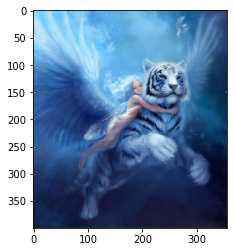

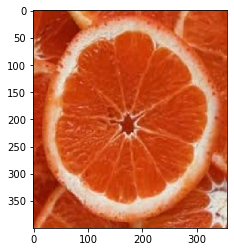

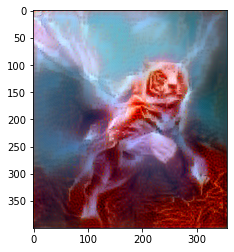

In [10]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()